In [2]:
%%capture
%pip install numpy
%pip install matplotlib

(array([[ 1.78568733e-04],
       [ 2.67728799e-01],
       [ 5.59305259e-01],
       [ 8.10832755e-01],
       [ 9.70662452e-01],
       [ 1.01575895e+00],
       [ 9.51741464e-01],
       [ 8.00106694e-01],
       [ 5.83491732e-01],
       [ 3.18707463e-01],
       [ 1.99962855e-02],
       [-2.92412776e-01],
       [-5.86505098e-01],
       [-8.21438790e-01],
       [-9.59553081e-01],
       [-9.81452723e-01],
       [-8.95283293e-01],
       [-7.34228764e-01],
       [-5.43416387e-01],
       [-3.63649943e-01]]), array([[ 1.13534461e-07, -3.00164258e-05, -2.31518722e-05,
         1.61853529e-06,  1.88472527e-05,  1.61248687e-05,
         7.39901310e-07, -1.01560020e-05, -5.22880331e-06,
         1.30842085e-05,  3.27503465e-05,  4.22512374e-05,
         3.77207000e-05,  2.31876844e-05,  6.12522373e-06,
        -7.27631705e-06, -1.43556421e-05, -1.56452804e-05,
        -1.32964531e-05, -9.57425544e-06],
       [-3.00164258e-05,  8.15303150e-03,  6.44927847e-03,
        -4.61526050e-

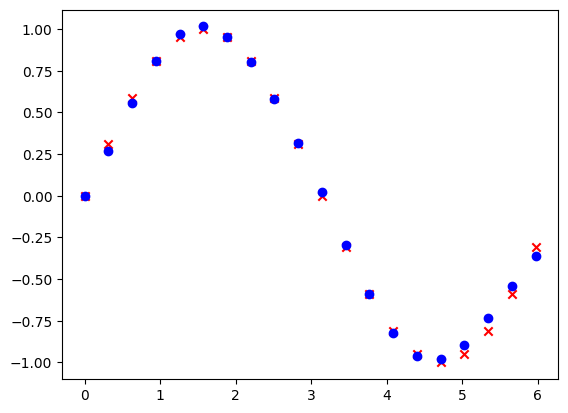

In [158]:
import numpy as np
import matplotlib.pyplot as plt

class Plotter():
    def __init__(self, gp_obj):
        self.gp = gp_obj
    
    def plot_covar_mat(self):
        plt.imshow(self.gp.covar_mat)
        plt.colorbar()
        plt.show()
    
    def plot_pred_vs_real(self):
        plt.scatter(self.gp.data.x_test, self.gp.data.y_test, marker='x', color='red')
        print(self.gp.y_pred)
        plt.scatter(self.gp.data.x_test, self.gp.y_pred[0], marker = 'o', color='blue')
        plt.show()

class Test_Data_Generator():
    def __init__(self, random_gen : bool = True, set_seed : int = 1):
        self.random_gen = random_gen
        self.set_seed = set_seed

    def sine_wave_1d(self, n_train, n_test):
        if not self.random_gen:
            np.random.seed(self.set_seed)

        x_test = (np.arange(stop = 1, step=1/n_test)*2*np.pi).reshape(-1,1)
        x_train = (np.random.rand(n_train)*2*np.pi).reshape(-1,1)
        y_train = (np.sin(x_train)).reshape(-1,1)
        y_test = (np.sin(x_test)).reshape(-1,1)
        return {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}

    def random_noise_2d(self, n_train, n_test):
        if not self.random_gen:
            np.random.seed(self.set_seed)

        x_train = np.random.rand(n_train,2)
        y_train = np.random.rand(n_train,2)
        x_test = np.random.rand(n_test,2)
        y_test = np.random.rand(n_test,2)

        return {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}

    def random_noise_2dx_1dy(self, n_train, n_test):
        x_train = np.random.rand(n_train,2)
        y_train = np.random.rand(n_train,1)
        x_test = np.random.rand(n_test,2)
        y_test = np.random.rand(n_test,1)

        return {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}


class Data():
    '''holds all of the stuff that doesn't change between GPs
    1d data is also listed as vectors as well treat scalar vals or 1d as 
    1 dimentional or single element vectors
    '''
    def __init__(self,x_train = None, x_test = None, y_train = None, y_test = None):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        return
    
    def fill_data(self, funciton, *args):
        data_dict = funciton(*args)
        for key, value in data_dict.items():
            setattr(self, key, value)
    
    def plot_1d(self):
        """Plots 1d Data"""
        plt.scatter(self.x_train, self.y_train, marker='o', color='b')
        plt.scatter(self.x_test, self.y_test, marker='x', color='r')
        return


class GP_Kernels():
    # can i use self if i don't pass the object as an arg into my gp funciton bc currenclty i can't
    # add funcitons unless they are embedded in whichever funciton im using
    def SquaredExponential(x_arr, **kwargs):
        ans = []
        for x_vec_star in x_arr:
            row = []
            for x_vec in x_arr:
                k = np.exp(-0.5*(x_vec-x_vec_star).T @ (np.diag(kwargs['length'])) @ (x_vec-x_vec_star))
                row.append(k)
            ans.append(row)
        ans = np.array(ans)
        return np.array(kwargs['sd']**2 * ans)


class GP():
    def __init__(self, data, hyperparams):
        self.data = data
        self.kernel = hyperparams['kernel']
        del hyperparams['kernel'] # technically we don't need to do this it doesn't really matter
        self.hyperparams = hyperparams
        self.solve_gp()
        Plotter(self).plot_pred_vs_real()


    def gen_covar_mat(self):
        x_arr = np.vstack((self.data.x_train , self.data.x_test))
        self.covar_mat = self.kernel(x_arr, **self.hyperparams)
        # print(self.covar_mat.shape)
        # print(f'x_train: {self.data.x_train.shape}, x_test: {self.data.x_test.shape}')
        
        Rtr, Ctr = self.data.x_train.shape
        d = Rtr
        # Rts, Cts = self.data.x_test.shape
        self.S11 = self.covar_mat[:d,:d]
        self.S22 = self.covar_mat[d:,d:]
        self.S12 = self.covar_mat[:d,d:]
        self.S21 = self.S12.T


    def solve_gp(self):
        self.gen_covar_mat()

        self.S11inv = np.linalg.inv(self.S11)

        mu = self.S21 @ self.S11inv @ self.data.y_train

        covar = self.S22 - self.S21 @ self.S11inv @ self.S12
        self.y_pred =  mu, covar



class GP_Eval():
    # could just be in gp i doubt it will chnage or need access to more than one gp at a time
    def __init__(self):
        return

class BayesOpt():
    def __init__(self, data):
        self.data = data
        # obviously there should be some logic to set this not just an arbitraray choice like the one here
        self.kernel = GP_Kernels.SquaredExponential 
        return

    def step_function(self):
        # do some logic on deciding the next hyperparams to look at
        # then senf off to the GP to make the model might have to treat
        # GP as a stack and offload unused GPS and just save performace
        # metrics
        return

    
    def find_optimal(self):
        for _ in self.steps:
            self.step_function()
    
    def test(self):
        hyperparams = {'kernel':self.kernel, 'sd':1, 'length':[1]}
        GP(self.data, hyperparams)


def main():
    data_generator = Test_Data_Generator(False, 1)
    data_1d = Data()#
    data_2d = Data()
    data_2d.fill_data(data_generator.random_noise_2dx_1dy, 5,10)

    data_1d.fill_data(data_generator.sine_wave_1d, 5,20)

    BayesOpt(data_1d).test()
    # BayesOpt(data_1d).test()
    return

main()

the kernel function is completely wrong it should be additive for the vector comparisons, I really should have checked that 
the equation is:
![image](images/kernelEquationVecObservations.png)